In [28]:
import numpy as np
import torch
import onnx
import onnxruntime
from onnxruntime import quantization
import os
from onnxruntime.quantization import QuantFormat, QuantType, quantize_static, CalibrationDataReader
from PIL import Image
import time
from matplotlib import pyplot as plt

In [2]:
model_fp32_path = '/home/ayush/OptiDepth/model_mirrornet.onnx'
model_prep_path = '/home/ayush/OptiDepth/model_mirrornet_prep.onnx'

# quantization.shape_inference.quant_pre_process(model_fp32_path, model_prep_path, skip_symbolic_shape=False)

In [3]:
session = onnxruntime.InferenceSession(model_prep_path, None)
(batch, _, height, width) = session.get_inputs()[0].shape
print(batch,height, width)
session.get_inputs()[0].name

1 384 384


'input.1'

In [11]:
def _preprocess_images(images_folder: str, height: int, width: int, size_limit=0):
    """
    Loads a batch of images and preprocess them
    parameter images_folder: path to folder storing images
    parameter height: image height in pixels
    parameter width: image width in pixels
    parameter size_limit: number of images to load. Default is 0 which means all images are picked.
    return: list of matrices characterizing multiple images
    """
    image_names = os.listdir(images_folder)
    if size_limit > 0 and len(image_names) >= size_limit:
        batch_filenames = [image_names[i] for i in range(size_limit)]
    else:
        batch_filenames = image_names
    unconcatenated_batch_data = []

    for image_name in batch_filenames:
        image_filepath = images_folder + "/" + image_name
        pillow_img = Image.new("RGB", (width, height))
        pillow_img.paste(Image.open(image_filepath).resize((384, 384)))
        input_data = np.float32(pillow_img) - np.array(
            [123.68, 116.78, 103.94], dtype=np.float32
        )
        nhwc_data = np.expand_dims(input_data, axis=0)
        nchw_data = nhwc_data.transpose(0, 3, 1, 2)  # ONNX Runtime standard
        unconcatenated_batch_data.append(nchw_data)
    batch_data = np.concatenate(
        np.expand_dims(unconcatenated_batch_data, axis=0), axis=0
    )
    return batch_data


class ResNet50DataReader(CalibrationDataReader):
    def __init__(self, calibration_image_folder: str, model_path: str):
        self.enum_data = None

        # Use inference session to get input shape.
        session = onnxruntime.InferenceSession(model_path, None)
        (_, _, height, width) = session.get_inputs()[0].shape

        # Convert image to input data
        self.nhwc_data_list = _preprocess_images(
            calibration_image_folder, height, width, size_limit=5
        )
        self.input_name = session.get_inputs()[0].name
        self.datasize = len(self.nhwc_data_list)

    def get_next(self):
        if self.enum_data is None:
            self.enum_data = iter(
                [{self.input_name: nhwc_data} for nhwc_data in self.nhwc_data_list]
            )
        return next(self.enum_data, None)

    def rewind(self):
        self.enum_data = None

In [12]:
dr = ResNet50DataReader("/home/ayush/OptiDepth/MirrorNet/MSD/test/image", model_prep_path)

In [13]:
output_model_path = 'model_mirrornet_quant.onnx'
quantize_static(model_prep_path, output_model_path, dr, quant_format=QuantFormat.QDQ, 
                per_channel=False,weight_type=QuantType.QInt8,)
print("Calibrated and quantized model saved.")

Calibrated and quantized model saved.


In [17]:
def benchmark(model_path):
    session = onnxruntime.InferenceSession(model_path)
    input_name = session.get_inputs()[0].name

    total = 0.0
    runs = 10
    input_data = np.zeros((1, 3, 384, 384), np.float32)
    # Warming up
    _ = session.run([], {input_name: input_data})
    for i in range(runs):
        start = time.perf_counter()
        _ = session.run([], {input_name: input_data})
        end = (time.perf_counter() - start) * 1000
        total += end
        print(f"{end:.2f}ms")
    total /= runs
    print(f"Avg: {total:.2f}ms")

In [18]:
print("benchmarking fp32 model...")
benchmark(model_fp32_path)

print("benchmarking int8 model...")
benchmark(output_model_path)

benchmarking fp32 model...
852.02ms
758.00ms
770.86ms
761.90ms
746.39ms
754.04ms
776.27ms
865.11ms
922.88ms
859.23ms
Avg: 806.67ms
benchmarking int8 model...
350.98ms
356.07ms
358.03ms
358.86ms
362.12ms
358.16ms
325.64ms
322.41ms
325.02ms
341.34ms
Avg: 345.86ms


[1, 3, 384, 384]
(1, 1, 384, 384)
[[77 73 70 ... 89 92 95]
 [76 70 68 ... 86 89 92]
 [73 68 65 ... 86 86 89]
 ...
 [70 68 65 ... 57 57 58]
 [73 70 68 ... 57 58 58]
 [76 73 73 ... 58 58 61]]


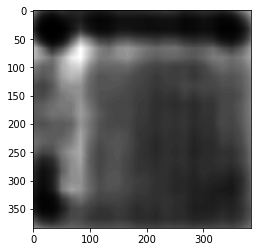

In [39]:
import torchvision.transforms as transforms

session = onnxruntime.InferenceSession(output_model_path)
input_name = session.get_inputs()[0].name
print(session.get_inputs()[0].shape)

image_filepath = '/home/ayush/OptiDepth/MirrorNet/MSD/test/image/387_512x640.jpg'
pillow_img = Image.new("RGB", (width, height))
pillow_img.paste(Image.open(image_filepath).resize((384, 384)))
input_data = np.float32(pillow_img)
nhwc_data = np.expand_dims(input_data, axis=0)
nchw_data = nhwc_data.transpose(0, 3, 1, 2)  # ONNX Runtime standard

output_data = session.run([], {input_name: nchw_data})
print(output_data[0].shape)
img_out_y = output_data[0][0][0]
pred_mask = (img_out_y*255).astype(np.uint8)
print(pred_mask)
plt.imshow(Image.fromarray(pred_mask), cmap='gray',)
plt.show()